In [26]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers, models

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [5]:
file = r'/Users/shiva/Desktop/Fall_Quarter_2023/ECS_171/Mulit-class Image classification/cifar-10-batches-py/batches.meta'
batches_meta_file = unpickle(file)
print(batches_meta_file)

data_batch_1_file = r'/Users/shiva/Desktop/Fall_Quarter_2023/ECS_171/Mulit-class Image classification/cifar-10-batches-py/data_batch_1'
dataset_1 = pd.Series(unpickle(data_batch_1_file))
#The size of the 1st data batch is (10000 , 3072):- It contains 10000 images and each image as 3072 numerical entries:- 1024 for Red, Green, Blue respectively.
image = dataset_1['data'][0]
# In the reshape function, the first argument represent the color scaling we are using, for our case, since we have colored image, therefore the color code is 3. And our each image is of the size 32 x 32 pixels.
image = image.reshape(3,32,32)
#print('After reshaping: ', image)
# the standard order of the axes is 0, 1, 2 which represents:- width x height x no. of channels. 
image = image.transpose(1,2,0)

{'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072}


(25, 32, 32, 3)


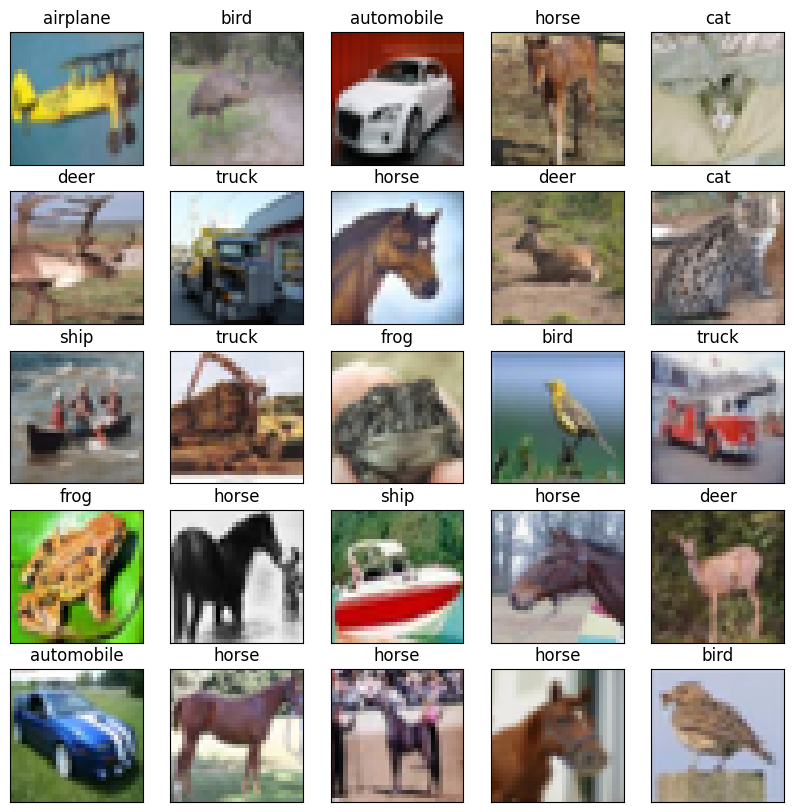

In [6]:
# Python 3 program to visualize 4th image
import matplotlib.pyplot as plt
import numpy as np
# take the images data from batch data
images = dataset_1['data']
# reshape and transpose the images
# the arguments to reshape function are of the form (nb_samples, nb_channels, width, height)
images = images.reshape(len(images),3,32,32).transpose(0, 2, 3, 1)
# take labels of the images 
labels = dataset_1['labels']
# label names of the images
label_names = batches_meta_file['label_names']
# display random images
# define row and column of figure
rows, columns = 5, 5
# take random image idex id
imageId = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images = images[imageId]
print(images.shape)
# take labels for these images only
labels = [labels[i] for i in imageId]
# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(label_names[labels[i-1]]))
plt.show()


### EDA(Exploratory Data Analysis)

In [24]:
dataset_array = []
#opening all the necessary datasets to get an estimate of the number of images for each class

data_batch_2_file = r'/Users/shiva/Desktop/Fall_Quarter_2023/ECS_171/Mulit-class Image classification/cifar-10-batches-py/data_batch_2'
dataset_2 = pd.Series(unpickle(data_batch_2_file))

data_batch_3_file = r'/Users/shiva/Desktop/Fall_Quarter_2023/ECS_171/Mulit-class Image classification/cifar-10-batches-py/data_batch_3'
dataset_3 = pd.Series(unpickle(data_batch_3_file))

data_batch_4_file = r'/Users/shiva/Desktop/Fall_Quarter_2023/ECS_171/Mulit-class Image classification/cifar-10-batches-py/data_batch_2'
dataset_4 = pd.Series(unpickle(data_batch_4_file))

data_batch_5_file = r'/Users/shiva/Desktop/Fall_Quarter_2023/ECS_171/Mulit-class Image classification/cifar-10-batches-py/data_batch_5'
dataset_5 = pd.Series(unpickle(data_batch_5_file))

dataset_array.append(dataset_1)
dataset_array.append(dataset_2)
dataset_array.append(dataset_3)
dataset_array.append(dataset_4)
dataset_array.append(dataset_5)

# In order to count the number of images for each class, we need to reshape the image array to appropiate dimensions and then assign labels to it. This is because the image array is an array of 3072 uint8 entries. After that we can count the number of images for each class label. 

num_cases_per_batch = batches_meta_file['num_cases_per_batch']

images_1 = dataset_1['data']
images_2 = dataset_2['data']
images_3 = dataset_3['data']
images_4 = dataset_4['data']
images_5 = dataset_5['data']

images_1 = images_1.reshape(num_cases_per_batch, 3, 32, 32).transpose(0, 2, 3, 1)
images_2 = images_2.reshape(num_cases_per_batch, 3, 32, 32).transpose(0, 2, 3, 1)
images_3 = images_3.reshape(num_cases_per_batch, 3, 32, 32).transpose(0, 2, 3, 1)
images_4 = images_4.reshape(num_cases_per_batch, 3, 32, 32).transpose(0, 2, 3, 1)
images_5 = images_5.reshape(num_cases_per_batch, 3, 32, 32).transpose(0, 2, 3, 1)

#the below array contains the name of labels(classes) from the meta_data file
label_names = batches_meta_file['label_names']

#the label of non-duplicate random image indexes
image_indexes = []
image_indexes.append(random.sample(range(num_cases_per_batch), num_cases_per_batch))

#extract the images from the image index for each dataset.
extracted_images_1 = images_1[image_indexes][0]
extracted_images_2 = images_2[image_indexes][0]
extracted_images_3 = images_3[image_indexes][0]
extracted_images_4 = images_4[image_indexes][0]
extracted_images_5 = images_5[image_indexes][0]

#labels for each dataset:- 
labels_1 = dataset_1['labels']
labels_2 = dataset_2['labels']
labels_3 = dataset_3['labels']
labels_4 = dataset_4['labels']
labels_5 = dataset_5['labels']

labels_1_indexed_number = [labels_1[i] for i in image_indexes[0]] 
labels_2_indexed_number = [labels_1[i] for i in image_indexes[0]] 
labels_3_indexed_number = [labels_1[i] for i in image_indexes[0]] 
labels_4_indexed_number = [labels_1[i] for i in image_indexes[0]] 
labels_5_indexed_number = [labels_1[i] for i in image_indexes[0]]

#print('For data batch-1:\n')
#rows, columns = 5, 5
#fig=plt.figure(figsize=(10, 10))
#for i in range(1, rows * columns + 1):
#    fig.add_subplot(rows, columns, i)
#    plt.imshow(extracted_images_1[i-1])
#    plt.xticks([])
#    plt.yticks([])
#    plt.title("{}"
#          .format(label_names[labels_1_indexed_number[i-1]]))
#plt.show()

#for i in range(num_cases_per_batch):
#    print(label_names[labels_1_indexed[i]])
count_1 = Counter(np.array(labels_1_indexed_number))
count_2 = Counter(np.array(labels_2_indexed_number))
count_3 = Counter(np.array(labels_3_indexed_number))
count_4 = Counter(np.array(labels_4_indexed_number))
count_5 = Counter(np.array(labels_5_indexed_number))
#contains the occurences of images in each class for each data-batch
counter_dictionary_databatch_1 = dict(count_1)
counter_dictionary_databatch_2 = dict(count_2)
counter_dictionary_databatch_3 = dict(count_3)
counter_dictionary_databatch_4 = dict(count_4)
counter_dictionary_databatch_5 = dict(count_5)
counter_dic = []
counter_dic.append(counter_dictionary_databatch_1)
counter_dic.append(counter_dictionary_databatch_2)
counter_dic.append(counter_dictionary_databatch_3)
counter_dic.append(counter_dictionary_databatch_4)
counter_dic.append(counter_dictionary_databatch_5)

## need to count the total number of images in each class label and then plot a histogram for it. 

### Trying to implement CNN

In [29]:
#cnn_model = models.Sequential()
#cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, #3)))
#cnn_model.add(layers.MaxPooling2D((2, 2)))
#cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#cnn_model.add(layers.MaxPooling2D((2, 2)))
#cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#cnn_model.summary()